# Analysis of Zillow Data

### Project goal

The project goal was to predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

### Acquiring data

The sole data source was the Zillow database. Data was wrangled using MySQL and Python. For detailed information on data preparation.........

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import LinearRegression
from math import sqrt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import env
import wrangle_z
import z_split_scale

In [4]:
df_z = wrangle_z.wrangle_zillow()

## Descriptive statistics

In [7]:
df_z.sample(5)

,Property Description,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
5446,Single Family Residential,1.0,2.0,848.0,220212.0,2860.35,6037.0
6310,Single Family Residential,4.0,4.0,3720.0,390365.0,4744.86,6037.0
4224,Single Family Residential,3.0,3.0,1654.0,427490.0,5147.46,6037.0
5324,Single Family Residential,2.0,3.0,1473.0,266738.0,3330.86,6037.0
15284,Single Family Residential,1.0,2.0,1117.0,605000.0,7245.81,6037.0


In [8]:
df_z.describe()

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
count,15963.000000,15963.000000,15963.000000,1.596300e+04,15963.000000,15963.000000
mean,2.215749,3.252835,1837.059199,4.633165e+05,5680.536779,6044.516758
std,1.026447,0.949797,984.656553,6.432976e+05,7465.277971,17.335701
min,1.000000,1.000000,320.000000,1.216800e+04,49.180000,6037.000000
25%,2.000000,3.000000,1233.000000,1.820635e+05,2495.545000,6037.000000
50%,2.000000,3.000000,1592.000000,3.204320e+05,4063.980000,6037.000000
75%,3.000000,4.000000,2162.500000,5.284255e+05,6408.970000,6037.000000
max,20.000000,25.000000,26345.000000,1.912982e+07,228999.210000,6111.000000


In [10]:
df_z.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15963 entries, 0 to 15962
Data columns (total 7 columns):
Property Description    15963 non-null object
Number of Bathrooms     15963 non-null float64
Number of Bedrooms      15963 non-null float64
Square Feet             15963 non-null float64
Tax Appraised Value     15963 non-null float64
Assessed Tax            15963 non-null float64
County Number           15963 non-null float64
dtypes: float64(6), object(1)
memory usage: 997.7+ KB


In [11]:
df_z.isnull().sum()

Property Description    0
Number of Bathrooms     0
Number of Bedrooms      0
Square Feet             0
Tax Appraised Value     0
Assessed Tax            0
County Number           0
dtype: int64

## Split variables into X and y, then train and test

In [12]:
X = df_z.drop(columns=['Property Description', 'Tax Appraised Value', 'Assessed Tax', 'County Number'])
y=df_z[['Tax Appraised Value']]

In [13]:
x_train, x_test, y_train, y_test = z_split_scale.split_my_data(X,y)

In [14]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12770 entries, 8477 to 3582
Data columns (total 3 columns):
Number of Bathrooms    12770 non-null float64
Number of Bedrooms     12770 non-null float64
Square Feet            12770 non-null float64
dtypes: float64(3)
memory usage: 399.1 KB


In [15]:
x_train.head()

,Number of Bathrooms,Number of Bedrooms,Square Feet
8477,2.5,3.0,1781.0
10275,2.0,4.0,1851.0
1659,3.0,6.0,2788.0
13290,1.0,3.0,1264.0
7209,2.0,3.0,1802.0


In [16]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3193 entries, 10657 to 3305
Data columns (total 1 columns):
Tax Appraised Value    3193 non-null float64
dtypes: float64(1)
memory usage: 49.9 KB


In [17]:
y_test.head()

,Tax Appraised Value
10657,208546.0
5788,137176.0
1185,227220.0
9415,220308.0
6987,395686.0


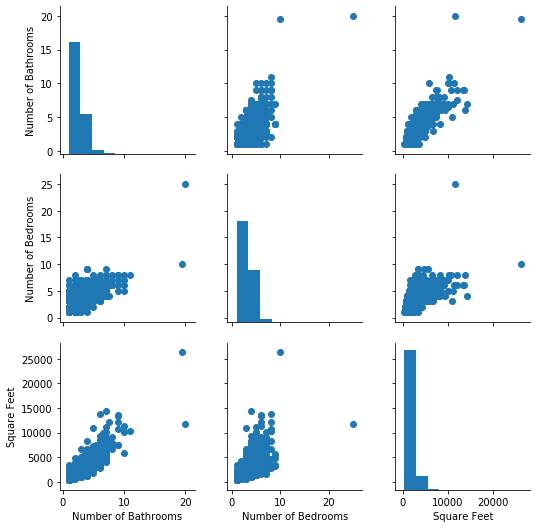

In [36]:
g = sns.PairGrid(x_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

## Apply standard scaler to x_train and x_test

In [18]:
train_x_scaled_data, test_x_scaled_data,scaler_x_train, scaler_x_test = z_split_scale.standard_scaler(x_train,x_test)

In [19]:
train_x_scaled_data.head()

,Number of Bathrooms,Number of Bedrooms,Square Feet
8477,0.278822,-0.262844,-0.054008
10275,-0.207660,0.783780,0.016880
1659,0.765304,2.877028,0.965763
13290,-1.180624,-0.262844,-0.577564
7209,-0.207660,-0.262844,-0.032742


In [20]:
test_x_scaled_data.head()

,Number of Bathrooms,Number of Bedrooms,Square Feet
10657,-1.199997,-1.359338,-1.057453
5788,-1.199997,-0.280182,-0.867332
1185,0.759144,-0.280182,0.151103
9415,0.759144,0.798974,0.844789
6987,-0.710212,-0.280182,-0.861165


## Run regression model on data and baseline

In [21]:
lm1 = LinearRegression()

In [22]:
lm1.fit(train_x_scaled_data, y_train)
print("Linear Model:", lm1)

lm1_y_intercept = lm1.intercept_
print("intercept: ", lm1_y_intercept)

lm1_coefficients = lm1.coef_
print("coefficients: ", lm1_coefficients)


Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [462043.62960063]
coefficients:  [[  54558.47376137 -137406.19237539  451263.14727761]]


In [23]:
y_pred_lm1 = lm1.predict(train_x_scaled_data)
y_pred_lm1

array([[489000.3946324 ],
       [350635.07111573],
       [544289.11543087],
       ...,
       [364555.6651571 ],
       [302651.54268246],
       [663497.55574983]])

In [24]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train, y_pred_lm1)
print('  {:.2%} of the variance in the tax value can be explained by the model.'.format(r2_lm1))

linear model
  mean squared error: 2.4e+11
  42.98% of the variance in the tax value can be explained by the model.


In [25]:
y_pred_baseline = np.array([y_train.mean()[0]]*len(y_train))
MSE = mean_squared_error(y_train, y_pred_baseline)
SSE = MSE*len(y_train)
RMSE = sqrt(MSE)

evs = explained_variance_score(y_train, y_pred_baseline)

print('baseline model\n  mean squared error: {:.5}'.format(MSE))
print('  {:.2%} of the variance in the tax value can be explained by the baseline (average) model.'.format(evs))

baseline model
  mean squared error: 4.2093e+11
  0.00% of the variance in the tax value can be explained by the baseline (average) model.


## Distribution of tax rates for each county

In [33]:
df_z['County Tax Rates'] = df_z['Assessed Tax']/df_z['Tax Appraised Value']

In [34]:
df_z.head()

,Property Description,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
0,Single Family Residential,2.0,4.0,1604.0,498347.0,6089.82,6037.0,0.012220
1,Single Family Residential,3.0,3.0,2384.0,549917.0,6679.55,6037.0,0.012146
2,Single Family Residential,2.0,3.0,1574.0,235272.0,3876.31,6037.0,0.016476
3,Single Family Residential,2.0,2.0,1619.0,340000.0,4206.15,6037.0,0.012371
4,Single Family Residential,3.0,2.0,2408.0,2017254.0,24353.42,6037.0,0.012073


In [46]:
v = df_z[df_z['County Number'] == 6111]
l = df_z[df_z['County Number'] == 6037]
o = df_z[df_z['County Number'] == 6059]

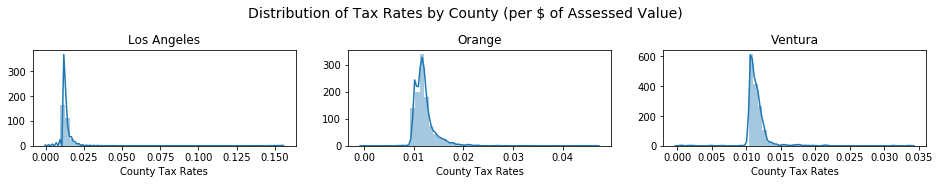

In [64]:
plt.figure(figsize=(16, 6))
plt.suptitle('Distribution of Tax Rates by County (per $ of Assessed Value)', fontsize=14)
plt.ylabel = 'Residence count'

plt.subplot(331)
sns.distplot(l['County Tax Rates'])
plt.title('Los Angeles')

plt.subplot(332)
sns.distplot(o['County Tax Rates'])
plt.title('Orange')

plt.subplot(333)
sns.distplot(v['County Tax Rates'])
plt.title('Ventura')
plt.show()

In [61]:
Los_Angeles_County = l.describe()
Los_Angeles_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,12388.000000,12388.000000,12388.000000,1.238800e+04,12388.000000,12388.0,12388.000000
mean,2.149661,3.177510,1772.191637,4.464855e+05,5611.552369,6037.0,0.013736
std,1.045680,0.956073,950.439448,6.415080e+05,7656.803041,0.0,0.003985
min,1.000000,1.000000,320.000000,1.216800e+04,125.950000,6037.0,0.000303
25%,1.000000,3.000000,1197.000000,1.700000e+05,2416.067500,6037.0,0.012147
50%,2.000000,3.000000,1532.000000,2.982050e+05,3911.960000,6037.0,0.012638
75%,3.000000,4.000000,2059.250000,4.944260e+05,6146.047500,6037.0,0.014012
max,20.000000,25.000000,14342.000000,1.912982e+07,228999.210000,6037.0,0.155072


In [63]:
Orange_County = o.describe()
Orange_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,2780.000000,2780.000000,2780.000000,2.780000e+03,2780.000000,2780.0,2780.000000
mean,2.462050,3.498201,2075.428058,5.483000e+05,6233.562180,6059.0,0.012111
std,0.947383,0.886708,1109.588740,7.094007e+05,7386.973146,0.0,0.002231
min,1.000000,1.000000,388.000000,1.611900e+04,345.720000,6059.0,0.000032
25%,2.000000,3.000000,1415.000000,2.465898e+05,2908.670000,6059.0,0.010805
50%,2.500000,3.000000,1853.000000,4.091510e+05,4706.300000,6059.0,0.011702
75%,3.000000,4.000000,2467.750000,6.488870e+05,7248.965000,6059.0,0.012622
max,19.500000,10.000000,26345.000000,1.168967e+07,121161.260000,6059.0,0.046414


In [65]:
Ventura_County = v.describe()
Ventura_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,795.000000,795.000000,795.000000,7.950000e+02,795.000000,795.0,795.000000
mean,2.384277,3.568553,2014.309434,4.284085e+05,4821.628931,6111.0,0.011491
std,0.819591,0.850999,890.610077,3.268902e+05,3587.999743,0.0,0.001842
min,1.000000,1.000000,572.000000,1.678200e+04,49.180000,6111.0,0.000367
25%,2.000000,3.000000,1444.500000,2.372000e+05,2716.540000,6111.0,0.010695
50%,2.000000,4.000000,1826.000000,3.732460e+05,4299.460000,6111.0,0.011203
75%,3.000000,4.000000,2356.000000,5.423780e+05,6053.900000,6111.0,0.011782
max,7.500000,6.000000,12086.000000,3.631311e+06,38677.720000,6111.0,0.033626
